# Install

In [1]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


# **Imports and Data**

In [2]:
# Importing Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importing time series specific libraries
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.statespace import sarimax
from statsmodels.tsa.stattools import kpss

# Libaraies for evaluation of model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from statsmodels.tsa.arima.model import ARIMAResults

# Read CSV file
data = pd.read_csv('productsales.csv')

# **Data Exploration**

In [4]:
# Read CSV file
data = pd.read_csv('productsales.csv')
data
data.describe()

,stall_id,product_type,number_sold
count,255640.000000,255640.000000,255640.000000
mean,3.000000,4.500000,781.838077
std,2.000004,2.872287,204.910291
min,0.000000,0.000000,234.000000
25%,1.000000,2.000000,722.000000
50%,3.000000,4.500000,836.000000
75%,5.000000,7.000000,916.000000
max,6.000000,9.000000,1205.000000


In [5]:
data['date']=pd.to_datetime(data['date'], infer_datetime_format=True)
data=data.set_index(['date'])
print(data.head())

            stall_id  product_type  number_sold
date                                           
2010-01-01         0             0          801
2010-01-02         0             0          810
2010-01-03         0             0          818
2010-01-04         0             0          796
2010-01-05         0             0          808


In [6]:
# Ensure sorted by date
data = data.sort_values(by='date')

# Preprocessing

In [7]:
# Total sales over time
total_sales  = data.groupby('date')['number_sold'].sum()
total_sales.describe(include = 'all')

count     3652.000000
mean     54728.665389
std        364.921063
min      53943.000000
25%      54451.000000
50%      54700.000000
75%      54939.000000
max      55952.000000
Name: number_sold, dtype: float64

In [8]:
# Calculate total sales by product type
product_sales = data.groupby('product_type')['number_sold'].sum()

# Identify the most and least sold product types
most_sold_product_type = product_sales.idxmax()
least_sold_product_type = product_sales.idxmin()

# Calculate total sales by store (stall id)
store_sales = data.groupby('stall_id')['number_sold'].sum()

# Identify the store with the most and least action figures sold
store_most_sold = store_sales.idxmax()
store_least_sold = store_sales.idxmin()

# Calculate average number sold per product type to see typical sales volume
avg_sales_per_product = data.groupby('product_type')['number_sold'].mean()

# Count how many sales transactions each store has to understand store activity level
store_transaction_counts = data.groupby('stall_id').size()

# Output results
print(f"Most sold product type: {most_sold_product_type}")
print(f"Least sold product type: {least_sold_product_type}")
print(f"Store with the most action figures sold: {store_most_sold}")
print(f"Store with the least action figures sold: {store_least_sold}")
print("\nAverage number sold per product type:")
print(avg_sales_per_product)
print("\nNumber of sales transactions per store:")
print(store_transaction_counts)

Most sold product type: 7
Least sold product type: 8
Store with the most action figures sold: 4
Store with the least action figures sold: 3

Average number sold per product type:
product_type
0    728.390588
1    804.634212
2    778.165271
3    741.837741
4    819.729111
5    803.831208
6    804.777030
7    832.966163
8    718.263143
9    785.786301
Name: number_sold, dtype: float64

Number of sales transactions per store:
stall_id
0    36520
1    36520
2    36520
3    36520
4    36520
5    36520
6    36520
dtype: int64


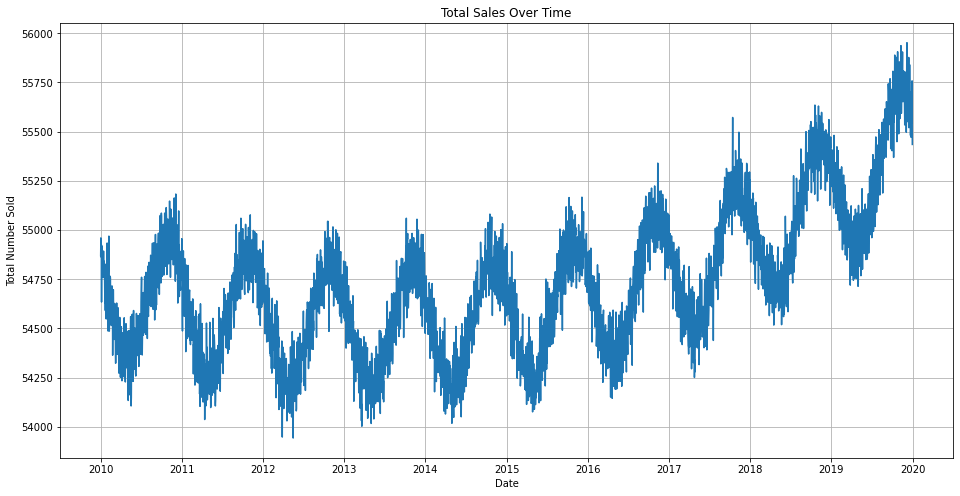

In [9]:
# Plot total sales over time
plt.figure(figsize=(16, 8))
plt.plot(total_sales)
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Number Sold')
plt.grid(True)
plt.show()

# ACF & PACF

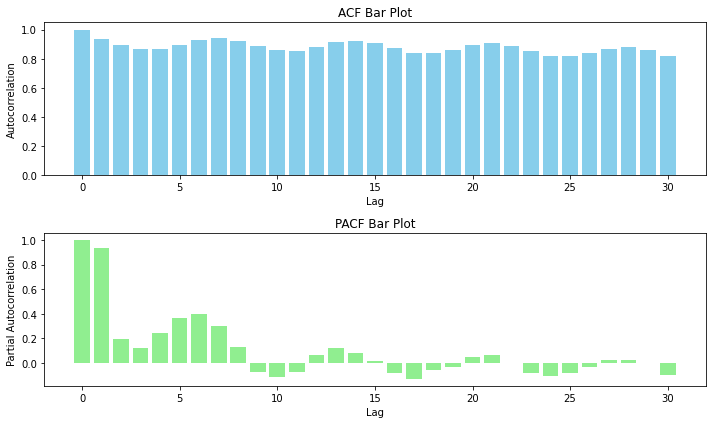

In [10]:
from statsmodels.tsa.stattools import acf, pacf

ts = pd.DataFrame(total_sales)
values = ts['number_sold']

# Calculate ACF and PACF values
acf_vals = acf(values, nlags=30)
pacf_vals = pacf(values, nlags=30)

plt.figure(figsize=(10,6))

plt.subplot(211)
plt.bar(range(len(acf_vals)), acf_vals, color='skyblue')
plt.title('ACF Bar Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')

plt.subplot(212)
plt.bar(range(len(pacf_vals)), pacf_vals, color='lightgreen')
plt.title('PACF Bar Plot')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Check for Stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller, kpss

# Run ADF and KPSS tests
adf_result = adfuller(total_sales)
kpss_result = kpss(total_sales, regression='c')  # 'c' = constant (level stationarity)

# Results for Augmented Dickey-Fuller (ADF) Test
print("Results of Dickey-Fuller Test:")

adf_stat = adf_result[0]
adf_pvalue = adf_result[1]
adf_lags = adf_result[2]
adf_nobs = adf_result[3]
adf_crit = adf_result[4]

print(f"{'Test Statistic':<10} {adf_stat:.6f}")
print(f"{'p-value':<10} {adf_pvalue:.6f}")
print(f"{'#Lags Used':<10} {adf_lags}")
print(f"{'Number of Observations Used':<10} {adf_nobs}")

for key in ['1%', '5%', '10%']:
    print(f"Critical Value ({key}){'':<5} {adf_crit[key]:.6f}")

# Results for KPSS Test
print("\nResults of KPSS Test:")

kpss_stat = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_lags = kpss_result[2]
kpss_crit = kpss_result[3]

print(f"{'Test Statistic':<10} {kpss_stat:.6f}")
print(f"{'p-value':<10} {kpss_pvalue:.6f}")
print(f"{'Lags Used':<10} {kpss_lags}")

for key in ['10%', '5%', '2.5%', '1%']:
    print(f"Critical Value ({key}){'':<5} {kpss_crit[key]:.6f}")

Results of Dickey-Fuller Test:
Test Statistic -2.500075
p-value    0.115456
#Lags Used 30
Number of Observations Used 3621
Critical Value (1%)      -3.432157
Critical Value (5%)      -2.862339
Critical Value (10%)      -2.567195

Results of KPSS Test:
Test Statistic 4.002083
p-value    0.010000
Lags Used  38
Critical Value (10%)      0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)      0.739000


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


# Differencing

NOTE: Simple Differencing is applied as I considered the plot as Linear. So wala na ung "period = 1" since for seasonal series ung ganon.

In [12]:
# Apply first differencing
first_difference = total_sales.diff().dropna()

# Run ADF and KPSS tests on first differenced series
adf_result_diff = adfuller(first_difference)
kpss_result_diff = kpss(first_difference, regression='c') 

# Results for ADF Test on First Differenced Series
print("Results of Dickey-Fuller Test (First Difference):")

adf_stat_diff = adf_result_diff[0]
adf_pvalue_diff = adf_result_diff[1]
adf_lags_diff = adf_result_diff[2]
adf_nobs_diff = adf_result_diff[3]
adf_crit_diff = adf_result_diff[4]

print(f"{'Test Statistic':<10} {adf_stat_diff:.6f}")
print(f"{'p-value':<10} {adf_pvalue_diff:.6f}")
print(f"{'#Lags Used':<10} {adf_lags_diff}")
print(f"{'Number of Observations Used':<10} {adf_nobs_diff}")
for key in ['1%', '5%', '10%']:
    print(f"Critical Value ({key}){'':<5} {adf_crit_diff[key]:.6f}")

# Results for KPSS Test on First Differenced Series
print("\nResults of KPSS Test (First Difference):")

kpss_stat_diff = kpss_result_diff[0]
kpss_pvalue_diff = kpss_result_diff[1]
kpss_lags_diff = kpss_result_diff[2]
kpss_crit_diff = kpss_result_diff[3]

print(f"{'Test Statistic':<10} {kpss_stat_diff:.6f}")
print(f"{'p-value':<10} {kpss_pvalue_diff:.6f}")
print(f"{'Lags Used':<10} {kpss_lags_diff}")
for key in ['10%', '5%', '2.5%', '1%']:
    print(f"Critical Value ({key}){'':<5} {kpss_crit_diff[key]:.6f}")

Results of Dickey-Fuller Test (First Difference):
Test Statistic -6.985473
p-value    0.000000
#Lags Used 30
Number of Observations Used 3620
Critical Value (1%)      -3.432158
Critical Value (5%)      -2.862339
Critical Value (10%)      -2.567195

Results of KPSS Test (First Difference):
Test Statistic 0.050265
p-value    0.100000
Lags Used  87
Critical Value (10%)      0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)      0.739000


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


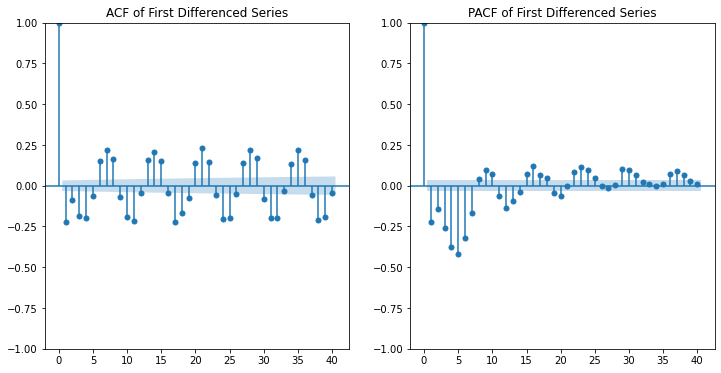

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(first_difference, lags=40, ax=plt.gca())
plt.title('ACF of First Differenced Series')

plt.subplot(122)
plot_pacf(first_difference, lags=40, ax=plt.gca())
plt.title('PACF of First Differenced Series')

plt.show()

# Auto-Arima

In [16]:
# Split the data into training and testing sets based on the specified years
train_data = total_sales[(total_sales.index >= '2010-01-01') & (total_sales.index <= '2018-12-31')]
test_data = total_sales[(total_sales.index >= '2019-01-01') & (total_sales.index <= '2019-12-31')]

# Fit the auto ARIMA model
model = pm.auto_arima(y=train_data)
results = model.fit(y=train_data)
print(results.summary())

# Make predictions on the training set (adjusting for differencing)
start_index = model.order[1]
train_predict = results.predict_in_sample(start=start_index, end=len(train_data)-1)
train_predict_series = pd.Series(train_predict, index=train_data.index[start_index:])

# Make predictions on the test set
predictions = results.predict(n_periods=len(test_data))
predictions_series = pd.Series(predictions, index=test_data.index)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3287
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -19608.930
Date:                Mon, 07 Jul 2025   AIC                          39235.859
Time:                        14:56:35   BIC                          39290.736
Sample:                    01-01-2010   HQIC                         39255.507
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6401      1.314      0.487      0.626      -1.936       3.216
ar.L1          0.5057      0.019     26.420      0.000       0.468       0.543
ar.L2         -0.5806      0.020    -29.645      0.0

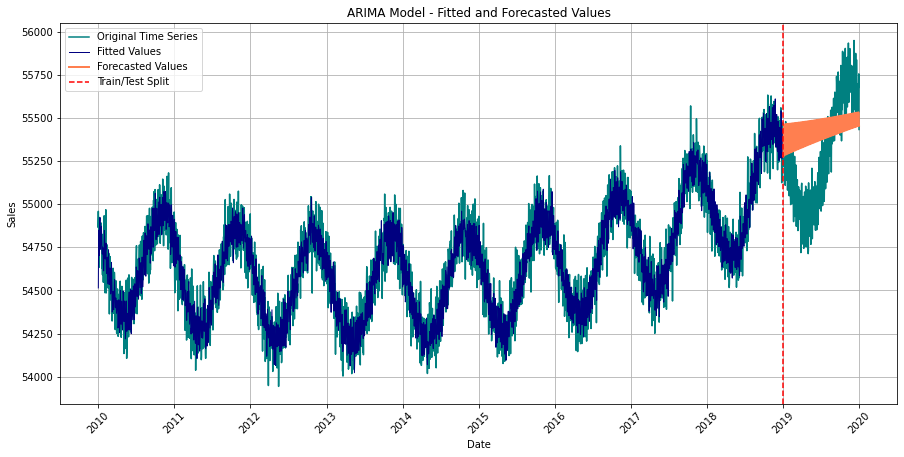

In [17]:
# Plot the results with transparency
plt.figure(figsize=(15, 7))
plt.plot(total_sales.index, total_sales, label='Original Time Series', color='teal')
plt.plot(train_predict_series.index, train_predict_series, label='Fitted Values', color='navy', linewidth=1)
plt.plot(predictions_series.index, predictions_series, label='Forecasted Values', color='coral', linewidth=2)
plt.axvline(train_data.index[-1], color='red', linestyle='--', label='Train/Test Split')
plt.legend()
plt.title('ARIMA Model - Fitted and Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Evaluate the model

In [18]:
# Align lengths of train_data and train_predict_series
train_data_aligned = train_data[start_index:]

# ================================
# Evaluation Metrics - Training Data
# ================================
print("Evaluation Results for Training Data (Auto-ARIMA):")

# Mean Squared Error
MSE_train = mean_squared_error(train_data_aligned, train_predict_series)
print(f"{'Mean Squared Error (MSE)':<40} = {MSE_train:.6f}")

# Mean Absolute Error
MAE_train = mean_absolute_error(train_data_aligned, train_predict_series)
print(f"{'Mean Absolute Error (MAE)':<40} = {MAE_train:.6f}")

# Root Mean Squared Error
RMSE_train = np.sqrt(MSE_train)
print(f"{'Root Mean Squared Error (RMSE)':<40} = {RMSE_train:.6f}")

# ================================
# Evaluation Metrics - Testing Data
# ================================
print("\nEvaluation Results for Testing Data (Auto-ARIMA):")

# Mean Squared Error
MSE_test = mean_squared_error(test_data, predictions_series)
print(f"{'Mean Squared Error (MSE)':<40} = {MSE_test:.6f}")

# Mean Absolute Error
MAE_test = mean_absolute_error(test_data, predictions_series)
print(f"{'Mean Absolute Error (MAE)':<40} = {MAE_test:.6f}")

# Root Mean Squared Error
RMSE_test = np.sqrt(MSE_test)
print(f"{'Root Mean Squared Error (RMSE)':<40} = {RMSE_test:.6f}")

Evaluation Results for Training Data (Auto-ARIMA):
Mean Squared Error (MSE)                 = 8924.151000
Mean Absolute Error (MAE)                = 75.595598
Root Mean Squared Error (RMSE)           = 94.467725

Evaluation Results for Testing Data (Auto-ARIMA):
Mean Squared Error (MSE)                 = 90084.112192
Mean Absolute Error (MAE)                = 254.985528
Root Mean Squared Error (RMSE)           = 300.140154
